In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
# Set dataset paths for Colab
train_path = "/content/drive/MyDrive/train"
val_path = "/content/drive/MyDrive/val"
test_path = "/content/drive/MyDrive/test"

# Define image size and batch size
IMAGE_SIZE = (224 , 224)
BATCH_SIZE = 32 #can change from 32 to 256

# Load training dataset
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    image_size=IMAGE_SIZE,  # Resize all images
    batch_size=BATCH_SIZE,
    shuffle=True
)

# Load val dataset
val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    val_path,
    image_size=IMAGE_SIZE,  # Resize all images
    batch_size=BATCH_SIZE,
    shuffle=True
)

# Load test dataset
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_path,
    image_size=IMAGE_SIZE,  # Resize all images
    batch_size=BATCH_SIZE,
    shuffle=True
)

# Get class names
class_names = test_dataset.class_names
print("Class Names:", class_names)


Found 18124 files belonging to 2 classes.
Found 1502 files belonging to 2 classes.
Found 1503 files belonging to 2 classes.
Class Names: ['0', '1']


In [15]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
val_dataset = val_dataset.map(lambda x, y: (normalization_layer(x), y))
test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))

Epoch 1/50
567/567 ━━━━━━━━━━━━━━━━━━━━ 100s 165ms/step - accuracy: 0.5801 - loss: 2.5923 - val_accuracy: 0.5866 - val_loss: 0.4988 - learning_rate: 0.0010
Epoch 2/50
567/567 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.6134 - loss: 0.5783 - val_accuracy: 0.5546 - val_loss: 0.5435 - learning_rate: 0.0010
Epoch 3/50
567/567 ━━━━━━━━━━━━━━━━━━━━ 25s 44ms/step - accuracy: 0.6348 - loss: 0.5578 - val_accuracy: 0.4834 - val_loss: 0.6419 - learning_rate: 0.0010
Epoch 4/50
567/567 ━━━━━━━━━━━━━━━━━━━━ 25s 44ms/step - accuracy: 0.6474 - loss: 0.5415 - val_accuracy: 0.4867 - val_loss: 0.6278 - learning_rate: 0.0010
Epoch 5/50
567/567 ━━━━━━━━━━━━━━━━━━━━ 25s 44ms/step - accuracy: 0.6500 - loss: 0.5349 - val_accuracy: 0.4394 - val_loss: 0.6724 - learning_rate: 5.0000e-04
Epoch 6/50
567/567 ━━━━━━━━━━━━━━━━━━━━ 25s 44ms/step - accuracy: 0.6587 - loss: 0.5241 - val_accuracy: 0.5719 - val_loss: 0.5433 - learning_rate: 5.0000e-04
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.6036 - loss:

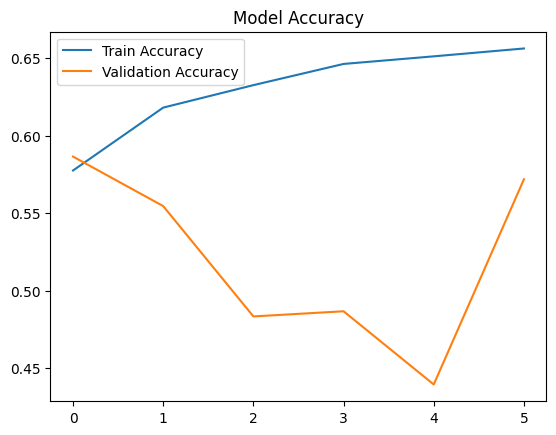

In [16]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Build CNN Model
model = tf.keras.Sequential([

    # Convolutional Layers
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),

    # Flatten & Dense Layers
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

# Compile the Model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Reduce the learning rate when the validation loss plateaus
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Define EarlyStopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',      # Monitor 'val_accuracy' or 'val_loss'
    patience=5,              # Number of epochs with no improvement after which training will stop
    restore_best_weights=True # Restore the weights from the epoch with the best validation loss
)

# Train the Model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    callbacks = [early_stopping,reduce_lr], #adjusting the hyperparammeters
    class_weight = {0:0.8,1:1.32}
)

# Evaluate the Model
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc:.2f}, Test Loss: {test_loss:.2f} ")

# Plot Training History
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title("Model Accuracy")
plt.show()

In [17]:
print(f"Test Accuracy: {test_loss:.2f}")

Test Accuracy: 0.52


47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step
              precision    recall  f1-score   support

           0       0.81      0.46      0.59      1210
           1       0.20      0.54      0.29       293

    accuracy                           0.48      1503
   macro avg       0.50      0.50      0.44      1503
weighted avg       0.69      0.48      0.53      1503



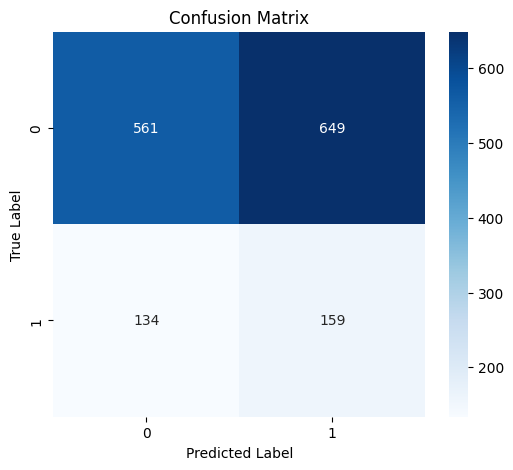

In [19]:
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix


y_true = np.concatenate([y.numpy() for _, y in test_dataset], axis=0)
y_pred_probs = model.predict(test_dataset).flatten()  # Get probabilities
y_pred = (y_pred_probs > 0.5).astype(int)

# Generate classification report
print(classification_report(y_true, y_pred,target_names = class_names))

# Plot confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step


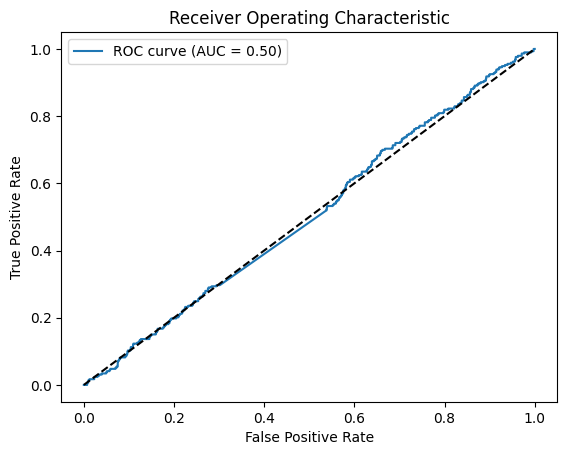

In [10]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


y_scores = model.predict(test_dataset).flatten()
# Assuming you have true labels (y_true) and predicted probabilities (y_scores)
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # diagonal line for reference
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend()
plt.show()